This notebook prepares the subject-level distances and between-subject distances for Chowell 2018 combined and kept subjects

This is the second step of the processing

There is another step of processing (st10) before this one

### HLA heterozygosity metrics for each subject

    depth on Zheng 2021 positive TCRs, set (mean_DePTH_set)
    
    glazer on Zheng 2021 positive TCRs, set (mean_CLAIRE_set)
    
    depth on Zheng 2021 positive TCRs, breadth (DePTH_breadth)
    
    glazer on Zheng 2021 positive TCRs, breadth (CLAIRE_breadth)

### optimal transport distance among subjects

    depth on Zheng 2021 pos TCRs, set (dist_DePTH_breadth)
    
    glazer on Zheng 2021 pos TCRs, set (dist_CLAIRE_breadth)

In [1]:
import pandas as pd
import numpy as np

import re

from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt

In [3]:
# load the two predicted score files

result_dir = "../results/"

depth_file = "st4_HLA_I_zheng_2021_ensemble_reshape_20.csv"
glazer_file = "st8_Glazer_2022_server_on_zheng_2021_pos_extended_hlas_146.csv" 

df_depth = pd.read_csv(result_dir + depth_file, header = 0)
df_glazer = pd.read_csv(result_dir + glazer_file, header = 0)

print(df_depth.shape)
print(df_glazer.shape)

(10008, 85)
(10008, 146)


In [4]:
# verify consistency between the columns of score files and the order in pseudo seq file
ori_data_dir = "../data/"
pseudo_file = "for_encoders/HLA_I_pseudo_40.csv"
df_pseudo = pd.read_csv(ori_data_dir + pseudo_file, header = 0)

In [5]:
Counter([a==b for a,b in zip(df_pseudo.hla.tolist(), df_depth.columns.tolist())])

Counter({True: 85})

In [6]:
# construct a dictionary of tcr index sets for HLAs
# use threshold 0.5

cutoff = 0.5

depth_hla_dict = defaultdict(set)
glazer_hla_dict = defaultdict(set)

hla_85_list = df_depth.columns.tolist()
hla_146_list = df_glazer.columns.tolist()

for hla in hla_85_list:
    hla_formatted = "".join(re.split('-|\*|:', hla)[1:])
    depth_cur_column = df_depth[hla].tolist()
    depth_hla_dict[hla_formatted] = set([i for i, x in enumerate(depth_cur_column) if x>=cutoff])


for hla in hla_146_list: 

    glazer_cur_column = df_glazer[hla].tolist()
    glazer_hla_dict[hla] = set([i for i, x in enumerate(glazer_cur_column) if x>=cutoff])

In [7]:
min([len(x) for x in depth_hla_dict.values()])

3368

In [8]:
max([len(x) for x in depth_hla_dict.values()])

6007

In [9]:
min([len(x) for x in glazer_hla_dict.values()])

2

In [10]:
max([len(x) for x in glazer_hla_dict.values()])

9880

In [11]:
# define a function to compute the distance between two sets

def set_dist(a, b):
    de = len(a.union(b))
    nu = len(a-b) + len(b-a)
    return(nu/de)

In [12]:
# load the previously extended subject feature file to add v allele heterozygosity score 
# using set distance

feature_file = "st10_chowell_2018_depth_glazer_aa_scores.csv"

df_2018_kept = pd.read_csv(result_dir + feature_file, header=0)

In [13]:
# create a dictionary for the distance between any two hla i alleles from 
# the 85 or 146 under consideration
hla_i_85_format = ["".join(re.split('-|\*|:', x)[1:]) for x in df_depth.columns.tolist()]
hla_i_146_format = df_glazer.columns.tolist()

# one dictionary based on associated TCRs from one resource
depth_dict = defaultdict(float)
glazer_dict = defaultdict(float)

for a in hla_i_85_format:
    cur_a_set = depth_hla_dict[a]
    for b in hla_i_85_format:
        cur_b_set = depth_hla_dict[b]
        depth_dict[(a, b)] = set_dist(cur_a_set, cur_b_set)

for a in hla_i_146_format:
    cur_a_set = glazer_hla_dict[a]
    for b in hla_i_146_format:
        cur_b_set = glazer_hla_dict[b]
        glazer_dict[(a, b)] = set_dist(cur_a_set, cur_b_set)

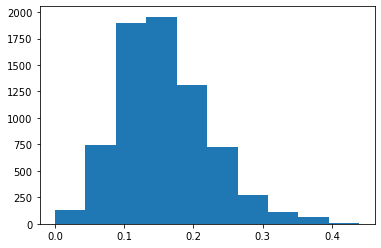

In [14]:
plt.hist(depth_dict.values())
plt.show()

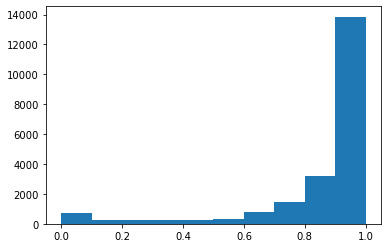

In [15]:
plt.hist(glazer_dict.values())
plt.show()

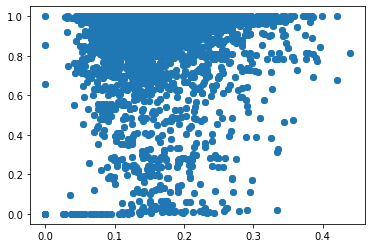

In [16]:
plot_depth_dict_keys = list(depth_dict.keys())
plot_depth_dict_values = [depth_dict[x] for x in plot_depth_dict_keys]
plot_glazer_dict_values = [glazer_dict[x] for x in plot_depth_dict_keys]

plt.scatter(plot_depth_dict_values, plot_glazer_dict_values)
plt.show()

In [17]:
df_2018_kept[:2]

,ID,age,age_group,os_months,os_event,mutcnt,gender,drug_class,cancer_type,stage_m,stage,reference,hla_class_i_alleles,homozygous,hla_class_i_alleles_replace,depth_ave,glazer_ave,aa_ave,log_mutcnt
0,CR0095,74.0,>71,67.936885,0.0,9.400000,M,CTLA-4,Melanoma,M1b,Stage 4,Snyder et al. 2014,"A0201,A3101,B3502,B3906,C0702,C0401",0.0,"A0201,A3101,B3502,B3906,C0702,C0401",0.039943,0.527117,0.266016,0.973590
1,CR04885,49.0,31-50,25.617525,0.0,70.066667,F,CTLA-4,Melanoma,M0,Stage 3,Snyder et al. 2014,"A0201,A3201,B0702,B1801,C0701,C0702",0.0,"A0201,A3201,B0702,B1801,C0701,C0702",0.033624,0.358978,0.239550,1.845573


In [18]:
# compute the distance based on both two set-based TCR resources for each subject


genotype_replace_list = [x.split(",") for x in df_2018_kept.hla_class_i_alleles_replace.tolist()]

set_depth_aa = []
set_depth_bb = []
set_depth_cc = []

for genotype in genotype_replace_list:
    set_depth_aa += [depth_dict[(genotype[0], genotype[1])]]
    set_depth_bb += [depth_dict[(genotype[2], genotype[3])]]   
    set_depth_cc += [depth_dict[(genotype[4], genotype[5])]]

set_depth_ave = [(x+y+z)/3 for x,y,z in zip(set_depth_aa, set_depth_bb, set_depth_cc)]



genotype_list = [x.split(",") for x in df_2018_kept.hla_class_i_alleles.tolist()]

set_glazer_aa = []
set_glazer_bb = []
set_glazer_cc = []

for genotype in genotype_list:
    set_glazer_aa += [glazer_dict[(genotype[0], genotype[1])]]
    set_glazer_bb += [glazer_dict[(genotype[2], genotype[3])]]   
    set_glazer_cc += [glazer_dict[(genotype[4], genotype[5])]]

set_glazer_ave = [(x+y+z)/3 for x,y,z in zip(set_glazer_aa, set_glazer_bb, set_glazer_cc)]

In [19]:
df_2018_kept["depth_set_ave"] = set_depth_ave
df_2018_kept["glazer_set_ave"] = set_glazer_ave

In [20]:
df_2018_kept.shape

(1443, 21)

In [21]:
df_2018_kept.columns.tolist()

['ID',
 'age',
 'age_group',
 'os_months',
 'os_event',
 'mutcnt',
 'gender',
 'drug_class',
 'cancer_type',
 'stage_m',
 'stage',
 'reference',
 'hla_class_i_alleles',
 'homozygous',
 'hla_class_i_alleles_replace',
 'depth_ave',
 'glazer_ave',
 'aa_ave',
 'log_mutcnt',
 'depth_set_ave',
 'glazer_set_ave']

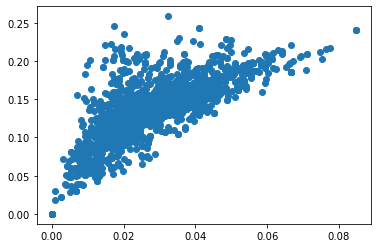

In [22]:
plt.scatter(df_2018_kept.depth_ave, df_2018_kept.depth_set_ave)
plt.show()

In [23]:
# compute hla breadth metric for each subject
# compute distances between subjects


# first, get list of sets with unioned set of TCRs as the set

depth_subject_list = []
glazer_subject_list = []

for geno in genotype_replace_list:
    
    six_depth_sets = [depth_hla_dict[geno[0]], depth_hla_dict[geno[1]], 
                      depth_hla_dict[geno[2]], depth_hla_dict[geno[3]],
                      depth_hla_dict[geno[4]], depth_hla_dict[geno[5]]]
                    
    cur_depth_union = set().union(*six_depth_sets)
                    
    depth_subject_list += [cur_depth_union]
    
    
for geno in genotype_list:
    
    six_glazer_sets = [glazer_hla_dict[geno[0]], glazer_hla_dict[geno[1]], 
                       glazer_hla_dict[geno[2]], glazer_hla_dict[geno[3]],
                       glazer_hla_dict[geno[4]], glazer_hla_dict[geno[5]]]
                    
    cur_glazer_union = set().union(*six_glazer_sets)
                    
    glazer_subject_list += [cur_glazer_union]  
    
    
# second, get hla breadth for each subject

depth_breadth = [len(x) for x in depth_subject_list]
glazer_breadth = [len(x) for x in glazer_subject_list]
   
    
df_2018_kept["depth_breadth"] = depth_breadth
df_2018_kept["glazer_breadth"] = glazer_breadth
    
    
# third, compute the set distances

set_depth_mat = []

for a in depth_subject_list:
    cur_depth_row = []
    for b in depth_subject_list:
        cur_depth_row += [set_dist(a, b)]
    set_depth_mat += [cur_depth_row]
    
set_glazer_mat = []

for a in glazer_subject_list:
    cur_glazer_row = []
    for b in glazer_subject_list:
        cur_glazer_row += [set_dist(a, b)]
    set_glazer_mat += [cur_glazer_row]

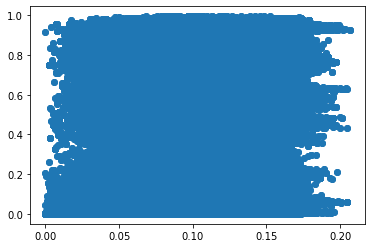

In [24]:
plt.scatter([x for cur in set_depth_mat for x in cur], 
            [x for cur in set_glazer_mat for x in cur])
plt.show()

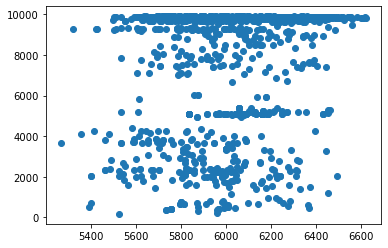

In [25]:
plt.scatter(df_2018_kept.depth_breadth, df_2018_kept.glazer_breadth)
plt.show()

In [26]:
# save the extended df_2018_kept file out
df_2018_kept.to_csv("../results/st11_chowell_2018_depth_glazer_aa_set_breadth.csv", 
                    index = False)

In [27]:
df_set_depth = pd.DataFrame(set_depth_mat)
df_set_depth.columns = df_2018_kept['ID'].tolist()

df_set_glazer = pd.DataFrame(set_glazer_mat)
df_set_glazer.columns = df_2018_kept['ID'].tolist()

In [28]:
df_set_depth.to_csv("../results/st11_chowell_2018_kept_depth_set_mat.csv", index = False)
df_set_glazer.to_csv("../results/st11_chowell_2018_kept_glazer_set_mat.csv", index = False)